In this project I'd like to make simple face recognition model based on metric learning ideology. Shortly, one would like to map images with face to some embedding space, where distance means similarity.\
There are two various strategies to do that - first solved this task straightly via minimizing distance between embeddings which are from the same class and maximizing distance between different classes embeddings, second strategy solves the task via proxy task - it classifies images and the penultimate activation is embedding.
+ #### First strategy.
 Classical loss here - is TripletLoss $min(ρ(A, P) - \rho(A,N) + Margin, 0)$, where A - anchor embedding, P - positiove sample(from the same class, as anchor), N - negative sample(class differs from anchor's class) and Margin - distance between groups. Of course, P and N have to be sampled in some way(this process called mining).
+ #### Second strategy.
Loss here is usual CrossEntropyLoss, but one can make such modifications - first, we would like to make spherical embeddings via fixating $bias=False, \|W_j\|=1, \|x\|=1$, then some margin-modifications can be made in soft-max, say
## $\frac{e^{s(cos(m_1θ_{y_j} + m_2) - m_3)}}{e^{s(cos(m_1θ_{y-j} + m_2) - m_3)} + ∑_{i \neq y_j} e^{s cos(\theta_i)}}$
Where s - sphere radius, $(m_1, m_2, m_3)$ - margins.

In [ ]:
!pip install faiss-gpu
!pip install faiss-cpu
!pip install face-alignment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 11.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 17.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for face-alignment: filename=face_alignment-1.3.5-py2.py3-none-any.whl size=28244 sha256=7d93ead2a230d40e599eaeb3b2172789279a9517d3574887bd08825b0f2b5a26
  Stored in directory: /root/.cache/pip/wheels/a2/86/13/a7930dedd3d2fa557138b68f283ef7b66902a7e853e253f26a
Successfully built face-alignment


In [ ]:
import random
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.notebook import tqdm
import os
import zipfile
from PIL import Image
from collections import defaultdict
import copy
from torch.nn import ReLU, Conv2d, BatchNorm2d, Sequential, AdaptiveAvgPool2d, Linear, MaxPool2d, Flatten, CrossEntropyLoss
try:
    import pytorch_lightning as pl
except:
    !pip install pytorch-lightning
    import pytorch_lightning as pl
try:
    import adabelief_pytorch
except:
    !pip install adabelief_pytorch==0.2.0
    time.sleep(1)
    import adabelief_pytorch
try:
    from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
except:
    !pip install pytorch_metric_learning
    time.sleep(1)
    from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
import ssl
import face_alignment
from skimage import io

ssl._create_default_https_context = ssl._create_unverified_context

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 17.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.3/109.3 KB 2.9 MB/s eta 0:00:00


In [ ]:
if not os.path.exists("drive"):
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs/

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # We'd like to use GPU
device

device(type='cuda', index=0)

In [ ]:
class CelebADataset:
    """
    Map-style dataset of celeb-faces, contain about 200k photoes of about 10k
    persons.
    --Class method make_train_test_dataset returns train and test datasets with
    adequate class-split structure (say, if there are 10 photoes of person A
    will train split contain 8 photoes, test split will contain remaining
    photoes, i.e. splitting works for classes)
    Args:
    -zip_path - path to zipfile which contains photoes
    -annotation_path - path to annotation file
    -extraction_path - path where photoes will be extracted
    -transform_train - transformation which will be applied to train images
    -transform_test - transformation which will be applied to test images
    -train_test_ration - multiplied by 100, this number shows the percentage of
    images will be placed in train dataset(other imgs will be placed to
    test_dataset)
    -seed - random seed, requires for reproducibility and ensembles
    -min_num_imgs_in_class - minimum number of classes when
    """
    def __init__(self, id_path_correspondence, transform=None):
        self.__id_path_correspondence = id_path_correspondence
        self.__transform = transform

    def __len__(self):
        return len(self.__id_path_correspondence)

    def __getitem__(self, idx):
        path, label = self.__id_path_correspondence[idx]
        img = torchvision.io.read_image(path, mode = torchvision.io.ImageReadMode.RGB)
        if self.__transform:
            img = self.__transform(img)
        return img, label

    def make_train_test_datasets(zip_path="drive/MyDrive/GitHub/NN studying/NN_studying/metric learning - face recognition(like FaceID)/data/img_align_celeba.zip",
                                 annotation_path = "drive/MyDrive/GitHub/NN studying/NN_studying/metric learning - face recognition(like FaceID)/data/identity_CelebA.txt",
                                 extract_path="",
                                 transform_train=None,
                                 transform_test=None,
                                 train_test_ratio=0.8,
                                 seed=42,
                                 min_num_imgs_in_class=10):
        if not extract_path == "":
            if extract_path[-1] != "/":
                extract_path += "/"

        if not os.path.exists(extract_path):
            data_zip = zipfile.ZipFile(zip_path)
            data_zip.extractall(extract_path)
            data_zip.close()

        extract_path += "img_align_celeba/"

        id_path_correspondence = {}
        with open(annotation_path) as f:
            for line in f:
                path, id = line.split('\n')[0].split(' ')
                id = int(id)
                if id in id_path_correspondence:
                    id_path_correspondence[id].append(extract_path + path)
                else:
                    id_path_correspondence[id] = [extract_path + path,]

        ids_to_delete = []
        for id, pathes in id_path_correspondence.items():
            if len(pathes) < min_num_imgs_in_class:
                ids_to_delete.append(id)
        for id_to_delete in ids_to_delete:
            id_path_correspondence.pop(id_to_delete)

        id_path_correspondence_clear = {}
        for i, (init_id, pathes) in enumerate(id_path_correspondence.items()):
            id_path_correspondence_clear[i] = pathes

        id_path_correspondence_train = []
        id_path_correspondence_test = []
        np.random.seed(seed)
        num_classes = 0
        for id, pathes in id_path_correspondence_clear.items():
            num_classes += 1
            mask = np.linspace(0, 1, len(pathes)) < train_test_ratio
            np.random.shuffle(mask)
            id_path_correspondence_train += list((path, id) for path,
                                                 mask_i in zip(pathes, mask) if mask_i)
            id_path_correspondence_test += list((path, id) for path,
                                                mask_i in zip(pathes, mask) if not mask_i)
        print("num_classes - {}".format(num_classes))

        return CelebADataset(id_path_correspondence_train, transform_train),\
         CelebADataset(id_path_correspondence_test, transform_test)

In [ ]:
class DigFaceDataset:
    """
    Map-style dataset, which takes data from zip-sourse
    Use make_train_test_dataset which return two datasets

    return tensor-object with shape (3, H, W), values are in range [0,255] with type uint8
    """
    def __init__(self, id_path_correspondence, transform=None):
        self.__id_path_correspondence = id_path_correspondence
        self.__transform = transform

    def __len__(self):
        return len(self.__id_path_correspondence)

    def __getitem__(self, id):
        path, label = self.__id_path_correspondence[id]
        img = torchvision.io.read_image(path, mode = torchvision.io.ImageReadMode.RGB)
        if self.__transform:
            img = self.__transform(img)
        return img, label

    def make_train_test_datasets(zip_path,
                                 extract_path="",
                                 transform_train=None,
                                 transform_test=None,
                                 train_test_ratio=0.8,
                                 seed=42):
        if extract_path == "":
            extract_path = "data/"
        else:
            extract_path += "/data/"

        if not os.path.exists(extract_path):
            data_zip = zipfile.ZipFile(zip_path)
            data_zip.extractall(extract_path)
            data_zip.close()

        face_ids = os.listdir(extract_path)

        id_path_correspondence_train = []
        id_path_correspondence_test = []
        np.random.seed(seed)
        for id in face_ids:
            img_names = os.listdir(extract_path+"/"+id)
            mask = np.random.rand(len(img_names))
            id_path_correspondence_train += list((extract_path+"/"+id+"/"+img_name, int(id)) for mask_i, img_name in zip(mask, img_names) if mask_i<train_test_ratio)
            id_path_correspondence_test += list((extract_path+"/"+id+"/"+img_name, int(id)) for mask_i, img_name in zip(mask, img_names) if mask_i>=train_test_ratio)

        return DigFaceDataset(id_path_correspondence_train, transform_train), DigFaceDataset(id_path_correspondence_test, transform_test)

In [ ]:
class UniformLabelsSampler:
    """Sample labels with equal probabilities."""
    def __init__(self, labels, labels_per_batch, num_batches):
        self._labels = set(labels)
        self._labels_per_batch = labels_per_batch
        self._num_batches = num_batches
        if len(self._labels) < labels_per_batch:
            raise ValueError("Can't sample equal number of labels. Batch is too large.")

    def __iter__(self):
        labels = list(self._labels)
        i = 0
        for _ in range(self._num_batches):
            if i + self._labels_per_batch > len(labels):
                random.shuffle(labels)
                i = 0
            yield list(labels[i:i + self._labels_per_batch])
            i += self._labels_per_batch


class ShuffledClassBalancedBatchSampler(torch.utils.data.Sampler):
    """Sampler which extracts balanced number of samples for each class.

    Args:
        data_source: Source dataset. Labels field must be implemented.
        batch_size: Required batch size.
        samples_per_class: Number of samples for each class in the batch.
            Batch size must be a multiple of samples_per_class.
    """

    def __init__(self, data_source, batch_size, samples_per_class):
        if batch_size > len(data_source):
            raise ValueError("Dataset size {} is too small for batch size {}.".format(
                len(data_source), batch_size))
        if batch_size % samples_per_class != 0:
            raise ValueError("Batch size must be a multiple of samples_per_class, but {} != K * {}.".format(
                batch_size, samples_per_class))

        self._data_source = data_source
        self._batch_size = batch_size
        self._labels_per_batch = self._batch_size // samples_per_class
        self._samples_per_class = samples_per_class
        labels = [i[1] for i in data_source]
        self._label_sampler = UniformLabelsSampler(labels, self._labels_per_batch,
                                                   num_batches=len(self))

        by_label = defaultdict(list)
        for i, label in enumerate(labels):
            by_label[label].append(i)
        self._by_label = list(by_label.values())
        if self._labels_per_batch > len(self._by_label):
            raise ValueError("Can't sample {} classes from dataset with {} classes.".format(
                self._labels_per_batch, len(self._by_label)))

    @property
    def batch_size(self):
        return self._batch_size

    def __iter__(self):
        for labels in self._label_sampler:
            batch = []
            for label in labels:
                batch.extend(np.random.choice(self._by_label[label], size=self._samples_per_class, replace=True))
            yield batch

    def __len__(self):
        num_samples = len(self._data_source)
        num_batches = num_samples // self._batch_size
        return num_batches

In [ ]:
class Embedder(torch.nn.Module):
    """
    Main part on network, maps images to embeddings, based on resnets
    Arg:
    embedding_dim -- size of embedding space

    cut_fc -- if False, after convolutions fully-conected layer will be applied,
    if False, there will be no fully-connected layer and very last
    convolutional block(resblock or bottleneck) will be replaced with usual conv
    with out_channels=embedding_dim

    reference_resnet -- describe the base model which will be modified

    after_relu -- if True, applies ReLU activation in the vety end.
    """
    __references = {'18' : (torchvision.models.resnet18, torchvision.models.ResNet18_Weights.DEFAULT, 1, 512),
                    '34' : (torchvision.models.resnet34, torchvision.models.ResNet34_Weights.DEFAULT, 2, 512),
                    '50' : (torchvision.models.resnet50, torchvision.models.ResNet50_Weights.DEFAULT, 2, 2048)}

    def __init__(self, embedding_dim = 128, cut_fc = False, reference_resnet = '18', after_relu=False):
        super(Embedder, self).__init__()
        self.cut_fc = cut_fc
        self.__embedding_dim = embedding_dim
        self.__reference_resnet = reference_resnet
        self.__after_relu = ReLU() if after_relu else None
        self.__build_resnet()

    def __build_resnet(self):
        ref_class, weights, layer, in_channels = Embedder.__references[self.__reference_resnet]

        self.__inner = ref_class(weights=weights)
        if not self.cut_fc:
            self.__inner.fc = Linear(in_channels, self.__embedding_dim)
        else:
            self.__inner.layer4[layer] = Conv2d(in_channels, self.__embedding_dim, kernel_size=3, padding=1, stride=1, bias=False)
            self.__flatten = torch.nn.Flatten()
            del(self.__inner.fc)

    @property
    def embedding_dim(self):
        return self.__embedding_dim

    def forward(self, x):
        if not self.cut_fc:
            if self.__after_relu:
                return self.__after_relu(self.__inner(x))
            else:
                return self.__inner(x)
        else:
            x = self.__inner.relu(self.__inner.bn1(self.__inner.conv1(x)))
            x = self.__inner.maxpool(x)
            x = self.__inner.layer1(x)
            x = self.__inner.layer2(x)
            x = self.__inner.layer3(x)
            x = self.__inner.layer4(x)
            x = self.__inner.avgpool(x)
            x = self.__flatten(x)
            if self.__after_relu:
                return self.__after_relu(x)
            else:
                return x

In [ ]:
def generate_triplets(embeddings, labels):
    """
    Function that takes embeddings and labels and makes hard negative and
    hard positive mining based on L2 distance

    Args:
    embeddings -- tensor (Batch_size, embedding_dim) which contains embeddings
    labels -- tensor (Batch_size, ) which contains corresponding to embeddings
    labels

    Output:

    embeddings -- initial embeddings
    positives -- hard positive samples which correspond with
    embeddings(same class, maximum distance)
    negatives -- hard negative samples which correspond with
    embeddings(different class, minimum distance)
    """
    pairwise_distances = torch.cdist(embeddings, embeddings)
    label_matches = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1))
    label_mismatches = torch.logical_not(label_matches)

    hard_negatives = torch.zeros_like(label_matches)
    hard_positives = torch.zeros_like(label_matches)
    for i in range(embeddings.size(0)):
        negative_distances = pairwise_distances[i][label_mismatches[i]]
        positive_distances = pairwise_distances[i][label_matches[i]]

        hard_negative_distance = torch.min(negative_distances)
        hard_positive_distance = torch.max(positive_distances)

        hard_negative_index = torch.logical_and(pairwise_distances[i] == hard_negative_distance, label_mismatches[i])
        hard_negative_index = torch.zeros_like(hard_negative_index).scatter_(0, (hard_negative_index * 1).argmax(0), 1).bool()

        hard_positive_index = torch.logical_and(pairwise_distances[i] == hard_positive_distance, label_matches[i])
        hard_positive_index = torch.zeros_like(hard_positive_index).scatter_(0, (hard_positive_index * 1).argmax(0), 1).bool()

        hard_negatives[i] = hard_negative_index
        hard_positives[i] = hard_positive_index

    hard_negative_indices = torch.nonzero(hard_negatives).squeeze()[:,1]
    hard_positive_indices = torch.nonzero(hard_positives).squeeze()[:,1]
    negatives = embeddings[hard_negative_indices]
    positives = embeddings[hard_positive_indices]
    return embeddings, positives, negatives

In [ ]:
class TripletLoss(torch.nn.Module):
    """
    Module whose forward-call return TripletLoss based on anchor(a), positive(p), negative(n) samples
    using formula min(d(a,p) - d(a, n) + margin, 0), where d(*, *) - L2-distance
    """
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        dist_ap = torch.sum((anchor - positive)**2, dim=1)
        dist_an = torch.sum((anchor - negative)**2, dim=1)
        loss = torch.clamp(dist_ap - dist_an + self.margin, min=0)
        loss = torch.mean(loss)
        return loss

As will be written below, one can add one more regularization to make classifier learn base-vectors on the sphere faster. This can be done with adding penalty to intra-class cosines, say,\
$-\frac{1}{\pi (N-1)}∑_{i \neq y_j}arccos(W^T_{y_j}*W_i)$

In [ ]:
class CombinedLoss(torch.nn.Module):
    """
    Module whose forward-call return combination of CrossEntropyLoss and
    TripletLoss
    """
    def __init__(self, triplet_margin=0.3, triplet_coeff=0.2, reg_coeff=0.1, gamma=0.99):
        super(CombinedLoss, self).__init__()
        self.__triplet_loss = TripletLoss(margin=triplet_margin)
        self.__ce = CrossEntropyLoss()
        self.__triplet_coeff = triplet_coeff
        self.__reg_coeff = reg_coeff
        self.__gamma = gamma

    def __angle_regularization(self, module, labels):
        weight = torch.nn.functional.normalize(module.weight)
        proper_rows = weight[labels]
        cosines = torch.nn.functional.linear(proper_rows, weight)
        angles = torch.arccos(cosines * self.__gamma)
        loss = torch.sum(angles, dim=1) / torch.pi
        return torch.mean(loss)

    def forward(self, anchor, positive, negative, logits, labels, module):
        loss = self.__ce(logits, labels)
        loss += self.__triplet_coeff * self.__triplet_loss(anchor, positive, negative)
        loss += self.__triplet_coeff * torch.mean((torch.sum(anchor**2, dim=1)-1)**2)
        loss -= self.__reg_coeff * self.__angle_regularization(module, labels)
        return loss

In [ ]:
class SphericalClassifier(torch.nn.Linear):
    """
    Last layer of network, solves metric learning task via classification
    forward-call takes data and targets and returns logits, inherited from
    linear layer, bias=False as apriori probability is 0 (embeddings live on the
    high-dim sphere).
    In train - calculate cosines -> calculate logits(contains margins)
    In test - calculate cosines (only!)
    """
    def __init__(self, in_features, out_features, scale = 64, margins=(1.0, 0, 0)):
        super(SphericalClassifier, self).__init__(in_features, out_features, bias=False)
        self._scale = scale
        self._margins = margins

    def __logits_calculator(self, cosines, target):
        m1, m2, m3 = self._margins
        one_hot = torch.zeros_like(cosines)
        one_hot.scatter_(1, target.view(-1, 1).long(), 1)

        req_cosines = torch.sum(one_hot * cosines, dim=1, keepdim=True)
        req_cosines = torch.cos(m2 + m1*torch.arccos(req_cosines))
        logits = self._scale * (cosines.scatter(dim=1,
                                               index=target.view(-1, 1).long(),
                                               src=req_cosines) - one_hot * m3)

        return logits

    def calculate_cosines(self, data):
        return torch.nn.functional.linear(torch.nn.functional.normalize(data),
                                  torch.nn.functional.normalize(self.weight))

    def forward(self, data, target):
        cosines = self.calculate_cosines(data)
        logits = self.__logits_calculator(cosines, target)
        return logits

In [ ]:
class MetricModule(pl.LightningModule):
    def __init__(self, config, REFERENCE_MODULE=None):
        super().__init__()
        self._config = config
        if REFERENCE_MODULE:
            self.embedder = REFERENCE_MODULE.embedder
            self.classifier = REFERENCE_MODULE.classifier
            self.criterion = REFERENCE_MODULE.criterion
        else:
            self.embedder = Embedder(embedding_dim = config['embedding_dim'],
                                    **config['embedder_params'])
            self.classifier = self.get_classifier()
            self.criterion = self.get_criterion()
        self.recall_calculator = AccuracyCalculator(
            include=("precision_at_1", "mean_average_precision_at_r"), k="max_bin_count"
        )

    def train_dataset(self):
        train_dataset = self._config["datasets"]["train_dataset"]
        return train_dataset

    def train_dataloader(self):
        dataset = self.train_dataset()

        params = self._config["datasets"]["params"]
        if "use_balanced_sampler" in params and params["use_balanced_sampler"]:
            sampler = ShuffledClassBalancedBatchSampler(
                dataset, params["batch_size"], params["samples_per_class"]
            )
            return torch.utils.data.DataLoader(
                dataset, batch_sampler=sampler
            )
        else:
            return torch.utils.data.DataLoader(
                dataset, params["batch_size"], shuffle=True, num_workers=self._config['num_workers']
            )

    def test_dataset(self):
        test_dataset = self._config["datasets"]["test_dataset"]
        return test_dataset

    def test_dataloader(self):
        dataset = self.test_dataset()
        params = self._config["datasets"]["params"]
        return torch.utils.data.DataLoader(
            dataset, batch_size = params["batch_size"], num_workers=self._config['num_workers']
        )

    def val_dataloader(self):
        return self.test_dataloader()

    def configure_optimizers(self):
        optimizer_params = self._config["optimization"]['params']
        optimizer_class = self._config['optimization']['optimizer']
        optimizer = optimizer_class(self.parameters(), **optimizer_params)

        self.link_to_optim = optimizer

        if 'scheduler' in self._config and self. _config['scheduler']:
            scheduler_class = self._config["scheduler"]['type']
            scheduler_params = self._config["scheduler"]['params']
            scheduler = {
                'scheduler' : scheduler_class(optimizer, **scheduler_params),
                'interval' : 'step' if self._config['scheduler']['step_every_batch'] else 'epoch'
            }
            return {'optimizer' : optimizer,
                    'lr_scheduler' : scheduler}
        else:
            return optimizer

    def get_criterion(self):
        criterion_type = self._config["criterion"]['type']
        params = self._config['criterion']["params"]
        return CRITERIONS[criterion_type](**params)

    def get_classifier(self):
        classifier_type = self._config['classifier']["type"]
        params = self._config['classifier']["params"]
        return CLASSIFIERS[classifier_type](self._config['embedding_dim'], self._config['num_classes'], **params)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        embeddings = self.embedder(images)
        if isinstance(self.criterion, torch.nn.CrossEntropyLoss):
            if isinstance(self.classifier, SphericalClassifier):
                logits = self.classifier(embeddings, labels)
            else:
                logits = self.classifier(embeddings)
            loss = self.criterion(logits, labels)
        elif isinstance(self.criterion, TripletLoss):
            anchor, positive, negative = generate_triplets(embeddings, labels)
            loss = self.criterion(anchor, positive, negative)
        elif isinstance(self.criterion, CombinedLoss):
            anchor, positive, negative = generate_triplets(embeddings, labels)
            logits = self.classifier(embeddings, labels)
            loss = self.criterion(anchor, positive, negative, logits, labels, self.classifier)
        self.log("loss", loss)
        self.log('lr', self.link_to_optim.state_dict()['param_groups'][0]['lr'])
        return {"loss": loss}

    def test_step(self, batch, batch_idx):
        images, labels = batch
        embeddings = self.embedder(images)
        if isinstance(self.criterion, TripletLoss):
            return {"embeddings" : embeddings.cpu(), "labels" : labels.cpu()}
        elif isinstance(self.criterion, CrossEntropyLoss):
            if isinstance(self.classifier, SphericalClassifier):
                pred = self.classifier.calculate_cosines(embeddings)
            else:
                pred = self.classifier(embeddings)
            correct = (pred.argmax(1) == labels).type(torch.float).sum().item()
            loss_val = self.criterion(pred, labels).item()
            return {"embeddings": embeddings.cpu(), "labels": labels.cpu(), "correct" : correct, "loss_val" : loss_val}
        elif isinstance(self.criterion, CombinedLoss):
            pred = self.classifier.calculate_cosines(embeddings)
            correct = (pred.argmax(1) == labels).type(torch.float).sum().item()
            return {"embeddings": embeddings.cpu(), "labels": labels.cpu(), "correct" : correct}

    def test_epoch_end(self, outputs) -> None:
        embeddings = np.vstack([b["embeddings"].numpy() for b in outputs])
        labels = np.hstack([b["labels"].numpy() for b in outputs])
        if self._config['classifier']['type'] == 'SphericalClassifier':
            embeddings = embeddings / np.sqrt((embeddings ** 2).sum(-1))[..., np.newaxis]
        metrics = self.recall_calculator.get_accuracy(
            embeddings, labels,
            embeddings, labels,
            ref_includes_query=True
        )
        if isinstance(self.criterion, CrossEntropyLoss):
            correct = sum(list(b["correct"] for b in outputs))
            loss_val = sum(list(b["loss_val"] for b in outputs))
            accuracy = correct / labels.shape[0]
            self.log("accuracy", accuracy)
            self.test_loss = loss_val
        if isinstance(self.criterion, CombinedLoss):
            correct = sum(list(b["correct"] for b in outputs))
            accuracy = correct / labels.shape[0]
            self.log("accuracy", accuracy)

        self.log("r_at_one", metrics["precision_at_1"])
        self.log("map_at_r", metrics["mean_average_precision_at_r"])

    def validation_step(self, batch, batch_idx):
        return self.test_step(batch, batch_idx)

    def validation_epoch_end(self, outputs) -> None:
        embeddings = np.vstack([b["embeddings"].numpy() for b in outputs])
        labels = np.hstack([b["labels"].numpy() for b in outputs])
        if self._config['classifier']['type'] == 'SphericalClassifier':
            embeddings = embeddings / np.sqrt((embeddings ** 2).sum(-1))[..., np.newaxis]
        metrics = self.recall_calculator.get_accuracy(
            embeddings, labels,
            embeddings, labels,
            ref_includes_query=True
        )
        if isinstance(self.criterion, CrossEntropyLoss):
            correct = sum(list(b["correct"] for b in outputs))
            accuracy = correct / labels.shape[0]
            self.log("accuracy", accuracy)

        self.log("val_r_at_one", metrics["precision_at_1"])
        self.log("val_map_at_r", metrics["mean_average_precision_at_r"])

In [ ]:
CRITERIONS = {'CE' : torch.nn.CrossEntropyLoss,
            'TripletLoss' : TripletLoss,
            'CombinedLoss' : CombinedLoss}

CLASSIFIERS = {'linear' : torch.nn.Linear,
              'SphericalClassifier' : SphericalClassifier}

config = {
    'num_workers' : 2,
    'embedder_params' : {
        'after_relu' : False,
        'cut_fc' : True,
        'reference_resnet' : '50'
    },
    'num_classes' : 10,
    'embedding_dim' : 128,
    'scheduler' : {
        'type' : torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
        'step_every_batch' : True,
        'params' : {
            'eta_min' : 1e-5,
            'T_0' : 1
        }
    },
    'optimization' : {
        'optimizer' : adabelief_pytorch.AdaBelief,
        'params' : {
            'lr' : 6e-4,
            'betas' : (0.9, 0.999),
            'eps' : 1e-8,
            'weight_decay' : 1e-3,
            'weight_decouple' : True,
            'rectify' : False,
            'fixed_decay' : False,
            'amsgrad' : False
        }
    },
    "datasets" : {
        "train_dataset" : None,
        "test_dataset" : None,
        "params" : {
            "batch_size" : 256,
            "use_balanced_sampler" : True,
            "samples_per_class" : 32,
        }
    },
    'criterion' : {
        'type' : 'CE',
        'params' : {}
    },
    'classifier': {
        'type' : 'SphericalClassifier',
        'params' : {
            'scale' : 48,
            'margins' : (1.25, 0.03, 0.007)
        }
    }
}

In [ ]:
class ToFloat:
    def __init__(self):
        pass

    def __call__(self, tensor):
        return tensor.float()

In [ ]:
test_transform = torchvision.transforms.Compose([ToFloat(),
                                                 torchvision.transforms.Normalize(mean=(129.0484, 108.4658,  97.5840), std=(79.0141, 73.8808, 73.7167))])
train_transform = torchvision.transforms.Compose([torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.IMAGENET),
                                                  ToFloat(),
                                                  torchvision.transforms.Normalize(mean=(129.0484, 108.4658,  97.5840), std=(79.0141, 73.8808, 73.7167))])

In [ ]:
train, test = CelebADataset.make_train_test_datasets(extract_path = 'data',
                                                     zip_path="drive/MyDrive/GitHub/NN studying/NN_studying/metric learning - face recognition(like FaceID)/data/img_align_celeba.zip",
                                 annotation_path = "drive/MyDrive/GitHub/NN studying/NN_studying/metric learning - face recognition(like FaceID)/data/identity_CelebA.txt",
                                                                   transform_train=train_transform,
                                                                   transform_test=test_transform)

In [ ]:
c_config = copy.deepcopy(config)
c_config['datasets']["train_dataset"] = train
c_config['datasets']["test_dataset"] = test
c_config['num_classes']=8369
c_config['classifier'] = {'type' : 'SphericalClassifier', 'params' : {'scale' : 48, 'margins' : (1.25, 0.02, 0.005)}}
c_config['datasets']['params'] = {'batch_size' : 128}
c_config['embedding_params'] = {
        'after_relu' : False,
        'cut_fc' : False,
        'reference_resnet' : '50'
    }
c_config['optimization']['params'] = {
            'lr' : 5e-4,
            'betas' : (0.9, 0.999),
            'eps' : 1e-8,
            'weight_decay' : 1e-2,
            'weight_decouple' : True,
            'rectify' : False,
            'fixed_decay' : False,
            'amsgrad' : False
        }

In [ ]:
module = MetricModule(c_config)

In [ ]:
logger = pl.loggers.TensorBoardLogger("./logs", name='CE, spherical_embeddings m=(1.25, 0.02, 0.005)')
trainer = pl.Trainer(
    accelerator="gpu",
    logger=logger,
    log_every_n_steps=10,
    max_epochs=5
)
trainer.fit(module)
trainer.test()

In [ ]:
module_cont = MetricModule(c_config, REFERENCE_MODULE=module)

In [ ]:
logger = pl.loggers.TensorBoardLogger("./logs", name='CE, spherical_embeddings m=(1.25, 0.02, 0.005), continue')
trainer = pl.Trainer(
    accelerator="gpu",
    logger=logger,
    log_every_n_steps=10,
    max_epochs=10
)
trainer.fit(module_cont)
trainer.test()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type                | Params
---------------------------------------------------
0 | embedder   | Embedder            | 21.4 M
1 | classifier | SphericalClassifier | 1.1 M 
2 | criterion  | CrossEntropyLoss    | 0     
---------------------------------------------------
22.5 M    Trainable params
0         Non-trainable params
22.5 M    Total params
89.904    Total estimated model params size (MB)


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ./logs/CE, spherical_embeddings m=(1.25, 0.02, 0.005), continue/version_1/checkpoints/epoch=4-step=5970.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint a

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        accuracy            0.8147948384284973
        map_at_r            0.4465596675872803
        r_at_one            0.6681464910507202
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'accuracy': 0.8147948384284973,
  'r_at_one': 0.6681464910507202,
  'map_at_r': 0.4465596675872803}]

In [ ]:
torch.save(module_cont.embedder, "drive/MyDrive/GitHub/NN studying/NN_studying/metric learning - face recognition(like FaceID)/best_models/embedder.tp")
torch.save(module_cont.classifier, "drive/MyDrive/GitHub/NN studying/NN_studying/metric learning - face recognition(like FaceID)/best_models/classifier.tp")

One will obtain difference between positive and negative distance distributions, however, their supports intersect, so one can't use simple distance-threshold, because it will often make false-authorizations or (if threshold isn't in negative distance distribution's support) will not find user.\
Simpliest solution is to make ensemble of embedders. Obtained embedding space is Cartesian product of set of spheres. Then some statistics must be collected - distances between embeddings that represent same class and distances between embeddings that represent different classes. And, finally, find a threshold.



In [ ]:
@torch.no_grad()
def make_embeddings(embedder, dataset):
    latent_space_dict = {}
    with torch.no_grad():
        with tqdm(total=len(dataset)) as pbar:
            for data in dataset:
                img, label = data
                img = img.reshape((1, *img.shape))
                img = img.to(device)
                embedding = embedder(img)
                embedding = embedding/torch.sqrt(torch.sum(embedding**2, dim=1, keepdim=True))
                if not label in latent_space_dict:
                    latent_space_dict[label] = embedding
                else:
                    latent_space_dict[label] = torch.cat((latent_space_dict[label], embedding), dim=0)
                pbar.update()
    return latent_space_dict

class EmbeddersEnsemble:
    def __init__(self, dataset, embedders):
        self.__embedders = embedders
        self.__dataset = dataset
        self.make_embeddings()

    @torch.no_grad()
    def make_embeddings(self):
        self.latent_space_dict = {}
        with tqdm(total=len(self.__dataset)) as pbar:
            for img, label in self.__dataset:
                pbar.update()

                img = img.reshape((1, *img.shape))
                img = img.to(device)
                embedding_pack = []
                for embedder in self.__embedders:
                    embedding = embedder(img)
                    embedding = embedding / torch.sqrt(torch.sum(embedding**2, dim=1, keepdim=True))
                    embedding_pack.append(embedding)
                if label in self.latent_space_dict:
                    final_embedding = []
                    for embedding_in_dict, embedding in zip(self.latent_space_dict[label], embedding_pack):
                        final_embedding.append(torch.cat((embedding_in_dict, embedding)))
                    self.latent_space_dict[label] = final_embedding
                else:
                    self.latent_space_dict[label] = embedding_pack

    @torch.no_grad()
    def distributions(self, embedding_dim=128):
        pos_distribution = []
        neg_distribution = []

        with tqdm(total=len(self.latent_space_dict)) as pbar:
            for label, embeddings_list in self.latent_space_dict.items():
                dist = 0

                random_index = np.random.randint(len(embeddings_list[0]))
                other_indices = torch.ones(len(embeddings_list[0]), dtype=bool)
                other_indices[random_index] = False
                for embeddings in embeddings_list:
                    random_embedding = embeddings[random_index].reshape(1, embedding_dim)
                    other_embeddings = embeddings[other_indices].reshape(-1, embedding_dim)
                    dist += torch.mean(torch.cdist(random_embedding, other_embeddings)).cpu().item()
                pos_distribution.append(dist)
                pbar.update()

        latent_space_keys = list(self.latent_space_dict.keys())
        with tqdm(total=len(self.latent_space_dict)) as pbar:
            for label, embeddings_list in self.latent_space_dict.items():
                dist = 0
                other_label = label
                while other_label == label:
                    other_label = np.random.choice(latent_space_keys)

                other_embeddings_list = self.latent_space_dict[other_label]
                other_index = np.random.randint(len(other_embeddings_list[0]))
                for other_embeddings, embeddings in zip(other_embeddings_list, embeddings_list):
                    other_index = np.random.randint(len(other_embeddings))
                    other_embedding = other_embeddings[other_index].reshape(1, embedding_dim)
                    dist += torch.mean(torch.cdist(other_embedding, embeddings)).cpu().item()
                neg_distribution.append(dist)
        return pos_distribution, neg_distribution

In [ ]:
class Statistic:
    def __init__(self, latent_space_dict):
        self._latent_space_dict = latent_space_dict

    @torch.no_grad()
    def calculate_statisctics_same_class(self):
        mean = 0
        n_props = 0
        std_squared = 0
        with tqdm(total=len(self._latent_space_dict)) as pbar:
            for label, embeddings in self._latent_space_dict.items():
                pairwise_distances = torch.cdist(embeddings, embeddings).cpu().numpy()
                distances_without_zeros = pairwise_distances[~np.eye(pairwise_distances.shape[0], dtype=bool)]
                mean += np.sum(distances_without_zeros)
                n_props += distances_without_zeros.shape[0]
                pbar.update()
        mean /= n_props
        print(mean)

        with tqdm(total=len(self._latent_space_dict)) as pbar:
            for label, embeddings in self._latent_space_dict.items():
                pairwise_distances = torch.cdist(embeddings, embeddings).cpu().numpy()
                distances_without_zeros = pairwise_distances[~np.eye(pairwise_distances.shape[0], dtype=bool)]
                std_squared += np.sum((distances_without_zeros - mean) ** 2)
                pbar.update()
        std_squared /= n_props
        std = np.power(std_squared, 0.5)
        print(std)
        return (mean, std)

    @torch.no_grad()
    def distances_diff_classes(self):
        dist_list = []
        with tqdm(total=len(self._latent_space_dict)) as pbar:
            indices = np.arange(0, len(self._latent_space_dict))
            for label, embeddings in self._latent_space_dict.items():
                other_label = label
                while other_label == label:
                    other_label = np.random.choice(indices)
                other_embeddings = self._latent_space_dict[other_label]
                dist = list(torch.cdist(embeddings, other_embeddings).reshape(-1).cpu().numpy())
                dist_list += dist
                pbar.update()
        return dist_list

    @torch.no_grad()
    def distances_same_classes(self):
        dist_list_same_class = []
        with tqdm(total=len(self._latent_space_dict)) as pbar:
            for label, embeddings in self._latent_space_dict.items():
                pairwise_distances = torch.cdist(embeddings, embeddings).cpu().numpy()
                distances_without_zeros = pairwise_distances[~np.eye(pairwise_distances.shape[0], dtype=bool)]
                pbar.update()
                dist_list_same_class += list(distances_without_zeros)
        return dist_list_same_class

    @torch.no_grad()
    def calculate_kth_momemt_same_class(self, k, central=True, embedding_dim=128):
        moments = []
        with tqdm(total=len(self._latent_space_dict)) as pbar:
            for label, embeddings in self._latent_space_dict.items():
                random_index = np.random.randint(len(embeddings))
                embedding_indices = torch.ones(len(embeddings), dtype=bool)
                embedding_indices[random_index] = False

                random_embedding = embeddings[random_index].reshape(1, -1)
                other_embeddings = embeddings[embedding_indices].reshape(-1, embedding_dim)

                pbar.update()
                pairwise_distances = torch.cdist(random_embedding, other_embeddings).cpu().numpy()
                if central:
                    mean = np.mean(pairwise_distances)
                    moment = np.mean(np.power(pairwise_distances - mean, k))
                    moments.append(moment)
                else:
                    moment = np.mean(np.power(pairwise_distances, k))
                    moments.append(moment)
        return moments

    @torch.no_grad()
    def calculate_kth_moment_diff_class(self, k, central=True):
        moments = []
        with tqdm(total=len(self._latent_space_dict)) as pbar:
            indices = np.arange(0, len(self._latent_space_dict))
            for label, embeddings in self._latent_space_dict.items():
                pbar.update()
                other_label = label
                while other_label == label:
                    other_label = np.random.choice(indices)
                other_embeddings = self._latent_space_dict[other_label]
                other_embedding = other_embeddings[np.random.randint(len(other_embeddings))].reshape(1, -1)
                pairwise_distances = torch.cdist(other_embedding, embeddings).cpu().numpy()
                if central:
                    mean = np.mean(pairwise_distances)
                    moment = np.mean(np.power(pairwise_distances - mean, k))
                    moments.append(moment)
                else:
                    moment = np.mean(np.power(pairwise_distances, k))
                    moments.append(moment)
        return moments

    @torch.no_grad()
    def calculate_asymmetry_same_class(self, embedding_dim=128):
        asymmetry_list = []
        with tqdm(total=len(self._latent_space_dict)) as pbar:
            for label, embeddings in self._latent_space_dict.items():
                pbar.update()
                random_index = np.random.randint(len(embeddings))
                embedding_indices = torch.ones(len(embeddings), dtype=bool)
                embedding_indices[random_index] = False

                random_embedding = embeddings[random_index].reshape(1, -1)
                other_embeddings = embeddings[embedding_indices].reshape(-1, embedding_dim)
                distances = torch.cdist(random_embedding, other_embeddings).cpu().numpy()

                mean = np.mean(distances)
                mu_3 = np.mean(np.power(distances - mean, 3))
                std_cube = np.power(np.std(distances), 3)
                asymmetry_list.append(mu_3 / std_cube)
        return asymmetry_list

    @torch.no_grad()
    def calculate_asymmetry_diff_class(self, embedding_dim=128):
        asymmetry_list = []
        with tqdm(total=len(self._latent_space_dict)) as pbar:
            indices = np.arange(0, len(self._latent_space_dict))
            for label, embeddings in self._latent_space_dict.items():
                pbar.update()
                other_label = label
                while other_label == label:
                    other_label = np.random.choice(indices)
                other_embeddings = self._latent_space_dict[other_label]
                other_embedding = other_embeddings[np.random.randint(len(other_embeddings))].reshape(1, -1)
                distances = torch.cdist(other_embedding, embeddings).cpu().numpy()

                mean = np.mean(distances)
                mu_3 = np.mean(np.power(distances - mean, 3))
                std_cube = np.power(np.std(distances), 3)
                asymmetry_list.append(mu_3 / std_cube)
        return asymmetry_list

    @torch.no_grad()
    def calculate_excess_same_class(self, embedding_dim=128):
        excess_list = []
        with tqdm(total=len(self._latent_space_dict)) as pbar:
            for label, embeddings in self._latent_space_dict.items():
                pbar.update()
                random_index = np.random.randint(len(embeddings))
                embedding_indices = torch.ones(len(embeddings), dtype=bool)
                embedding_indices[random_index] = False

                random_embedding = embeddings[random_index].reshape(1, -1)
                other_embeddings = embeddings[embedding_indices].reshape(-1, embedding_dim)
                distances = torch.cdist(random_embedding, other_embeddings).cpu().numpy()

                mean = np.mean(distances)
                mu_4 = np.mean(np.power(distances - mean, 4))
                std_4 = np.power(np.std(distances), 4)
                excess_list.append((mu_4 / std_4) - 3)
        return excess_list

    @torch.no_grad()
    def calculate_excess_diff_class(self, embedding_dim=128):
        excess_list = []
        with tqdm(total=len(self._latent_space_dict)) as pbar:
            indices = np.arange(0, len(self._latent_space_dict))
            for label, embeddings in self._latent_space_dict.items():
                pbar.update()
                other_label = label
                while other_label == label:
                    other_label = np.random.choice(indices)
                other_embeddings = self._latent_space_dict[other_label]
                other_embedding = other_embeddings[np.random.randint(len(other_embeddings))].reshape(1, -1)
                distances = torch.cdist(other_embedding, embeddings).cpu().numpy()

                mean = np.mean(distances)
                mu_4 = np.mean(np.power(distances - mean, 4))
                std_4 = np.power(np.std(distances), 4)
                excess_list.append((mu_4 / std_4) - 3)
        return excess_list

    @torch.no_grad()
    def calculate_func_same_class(self, func, embedding_dim=128):
        func_list = []
        with tqdm(total=len(self._latent_space_dict)) as pbar:
            for label, embeddings in self._latent_space_dict.items():
                pbar.update()
                random_index = np.random.randint(len(embeddings))
                embedding_indices = torch.ones(len(embeddings), dtype=bool)
                embedding_indices[random_index] = False

                random_embedding = embeddings[random_index].reshape(1, -1)
                other_embeddings = embeddings[embedding_indices].reshape(-1, embedding_dim)
                distances = torch.cdist(random_embedding, other_embeddings).cpu().numpy()

                func_list.append(func(distances))
        return func_list

    @torch.no_grad()
    def calculate_func_diff_class(self, func, embedding_dim=128):
        func_list = []
        with tqdm(total=len(self._latent_space_dict)) as pbar:
            indices = np.arange(0, len(self._latent_space_dict))
            for label, embeddings in self._latent_space_dict.items():
                pbar.update()
                other_label = label
                while other_label == label:
                    other_label = np.random.choice(indices)
                other_embeddings = self._latent_space_dict[other_label]
                other_embedding = other_embeddings[np.random.randint(len(other_embeddings))].reshape(1, -1)
                distances = torch.cdist(other_embedding, embeddings).cpu().numpy()

                func_list.append(func(distances))
        return func_list

In [ ]:
import sys
sys.path.append('drive/MyDrive/GitHub/NN studying/NN_studying/metric learning - face recognition(like FaceID)/libs')
import network_collection

embedder0 = torch.load("drive/MyDrive/GitHub/NN studying/NN_studying/metric learning - face recognition(like FaceID)/best_models/UnitedModel_best2(1.1_ 0.03_ 0.035).tp").embedder.to(device).eval()
embedder1 = torch.load("drive/MyDrive/GitHub/NN studying/NN_studying/metric learning - face recognition(like FaceID)/best_models/UnitedModel_best.tp").embedder.to(device).eval()
embedder2 = torch.load("drive/MyDrive/GitHub/NN studying/NN_studying/metric learning - face recognition(like FaceID)/best_models/UnitedModel_best3(1.3; 0.02; 0.007).tp").embedder.to(device).eval()

In [ ]:
e_ensemble = EmbeddersEnsemble(train, (embedder0, embedder1, embedder2))

In [ ]:
pos_distribution = []
neg_distribution = []
embedding_dim=128
how_many_neg_classes = 50

with torch.no_grad():
    with tqdm(total=len(e_ensemble.latent_space_dict)) as pbar:
        for label, embeddings_list in e_ensemble.latent_space_dict.items():
            dist = 0

            random_index = np.random.randint(len(embeddings_list[0]))
            other_indices = torch.ones(len(embeddings_list[0]), dtype=bool)
            other_indices[random_index] = False
            for embeddings in embeddings_list:
                random_embedding = embeddings[random_index].reshape(1, embedding_dim)
                other_embeddings = embeddings[other_indices].reshape(-1, embedding_dim)
                dist += torch.mean(torch.cdist(random_embedding, other_embeddings)).cpu().item()
            for _ in range(how_many_neg_classes):
                pos_distribution.append(dist)
            pbar.update()

    latent_space_keys = list(e_ensemble.latent_space_dict.keys())
    with tqdm(total=len(e_ensemble.latent_space_dict)) as pbar:
        for label, embeddings_list in e_ensemble.latent_space_dict.items():
            for _ in range(how_many_neg_classes):
                dist = 0
                other_label = label
                while other_label == label:
                    other_label = np.random.choice(latent_space_keys)

                other_embeddings_list = e_ensemble.latent_space_dict[other_label]
                other_index = np.random.randint(len(other_embeddings_list[0]))
                for other_embeddings, embeddings in zip(other_embeddings_list, embeddings_list):
                    other_index = np.random.randint(len(other_embeddings))
                    other_embedding = other_embeddings[other_index].reshape(1, embedding_dim)
                    dist += torch.mean(torch.cdist(other_embedding, embeddings)).cpu().item()
                neg_distribution.append(dist)
            pbar.update()

Before '3' posiive % - 95.5072290596248
Before '3' negative % - 0.009559087107181265


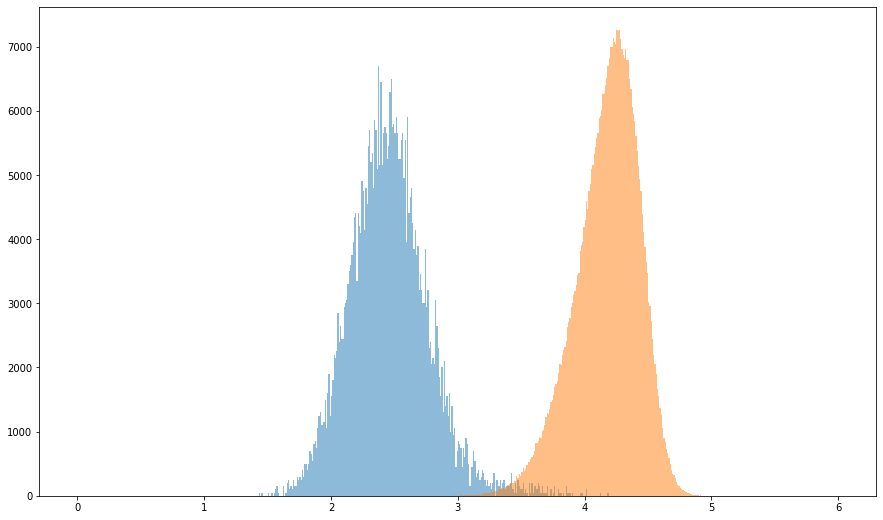

In [ ]:
plt.figure(figsize=(15, 9))
hist_p, bins, gen = plt.hist(pos_distribution, range=(0, 6), bins=600, alpha=0.5)
hist_n, bins, gen = plt.hist(neg_distribution, range=(0, 6), bins=600, alpha=0.5)
print("Before '3' posiive % - {}".format(sum(hist_p[:301]) / sum(hist_p) * 100))
print("Before '3' negative % - {}".format(sum(hist_n[:301]) / sum(hist_n) * 100))

As one can see, $threshold≈3$, it can be clarified with bigger dataset and with honest check - say, split dataset's classes in half, one half represents classes are in database(P), other half represents negative authorizations classes set(N). Then split set of images in each class in P into one image and another images - one image represents positive authorization set (AP), other images represent data in database(D). And choose one image in each N's class (AN).
###Test:
+ Take each image from AP, map it using ensemble, find class in D which is less that the threshold(T). If found class is the same as the test one from AP then this is a true authorization case (TA-AP), if found class is different from the test one from AP then this is a false authorization case (FA-AP), if there are no classes found or there are more that one classes found(this situation may be moderate) then this is a no-authorization case (NA). Number of FPA must be equal to zero, then number of NA should be minimal.
+ Take each image from AN, map it using ensemble, find class in D which is less that the threshold(T). If there is any class found in D then this is false authorization case (FA-AN), otherwise this is true no-authorization case (TNA). Number of FA-AN must equal to zero.
+ Find proper threshold

In [ ]:
import sys
sys.path.append('drive/MyDrive/GitHub/NN studying/NN_studying/face recognition/libs')
import network_collection

embedder0 = torch.load("drive/MyDrive/GitHub/NN studying/NN_studying/face recognition/best_models/UnitedModel_best2(1.1_ 0.03_ 0.035).tp").embedder.to(device).eval()
embedder1 = torch.load("drive/MyDrive/GitHub/NN studying/NN_studying/face recognition/best_models/UnitedModel_best.tp").embedder.to(device).eval()
embedder2 = torch.load("drive/MyDrive/GitHub/NN studying/NN_studying/face recognition/best_models/UnitedModel_best3(1.3; 0.02; 0.007).tp").embedder.to(device).eval()

In [ ]:
data_zip = zipfile.ZipFile("faces.zip")
data_zip.extractall("faces")
data_zip.close()

In [ ]:
def make_alignment(input, fa):
    preds = fa.get_landmarks(input)
    x_list = list(point[0] for point in preds[0])
    y_list = list(point[1] for point in preds[0])

    min_x = min(x_list)
    min_y = min(y_list)
    max_x = max(x_list)
    max_y = max(y_list)

    forehead_dy = 0.5 * (max_y-min_y)
    eps_y = 0.05 * (max_y - min_y)
    eps_x = 0.05 * (max_x - min_x)
    return (min_y - forehead_dy - eps_y,
                max_y + eps_y,
                min_x - eps_x,
                max_x + eps_x)

def crop_resize(img, box, base_width):
    min_y, max_y, min_x, max_x = box
    min_y = int(max(0, min_y))
    min_x = int(max(0, min_x))
    max_y = int(min(max_y, img.shape[-2]))
    max_x = int(min(max_x, img.shape[-1]))

    ratio = (max_y - min_y) / (max_x - min_x)
    cropped_img = img[:, min_y:max_y, min_x:max_x]
    cropped_resized_img = torchvision.transforms.functional.resize(cropped_img, (int(ratio * base_width), base_width))
    return cropped_resized_img

class Checker:
    def __init__(self,
                 database_path,
                 embedder_ensemble,
                 transform,
                 print_scores=False,
                 threshold=3.,
                 device='cpu',
                 base_width=100):
        self.__database_path = database_path
        self.__embedder_ensemble = embedder_ensemble
        self.__transform = transform
        self.face_alignment = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D,
                                                           flip_input=False,
                                                           device='cuda' if torch.cuda.is_available() else 'cpu')
        self.print_scores = print_scores
        self.threshold= threshold
        self.__base_width = 100
        self.device = device

        self.__make_embeddings_from_database()

    @torch.no_grad()
    def __make_embeddings_from_database(self):
        persons = os.listdir(self.__database_path)
        persons_img_pathes = {}
        for person in persons:
            path = self.__database_path + "/" + person + "/"
            pathes = os.listdir(path)
            persons_img_pathes[person] = list(self.__database_path + "/" + person + "/" + img_name for img_name in pathes)

        self.__persons_cropped_resized_transformed_imgs = {}
        with tqdm(total=len(persons_img_pathes)) as pbar:
            for person, pathes in persons_img_pathes.items():
                pbar.update()
                imgs = []
                for path in pathes:
                    img = io.imread(path)
                    box = make_alignment(img, self.face_alignment)
                    img = torch.from_numpy(img).transpose(0, 2).transpose(1, 2)
                    img = crop_resize(img, box, self.__base_width)
                    img = self.__transform(img).to(self.device)
                    img = img.reshape((1, *img.shape))
                    imgs.append(img)
                self.__persons_cropped_resized_transformed_imgs[person] = imgs

        self._persons_embeddings = {}
        with tqdm(total=len(self.__persons_cropped_resized_transformed_imgs)) as pbar:
            for person, imgs in self.__persons_cropped_resized_transformed_imgs.items():
                pbar.update()
                embeddings_list = []
                for embedder in self.__embedder_ensemble:
                    embeddings_e = None
                    for img in imgs:
                        embedding = embedder(img)
                        embedding /= torch.sqrt(torch.sum(embedding**2, dim=1, keepdim=True))
                        if embeddings_e is None:
                            embeddings_e = embedding
                        else:
                            embeddings_e = torch.cat((embeddings_e, embedding))
                    embeddings_list.append(embeddings_e)
                self._persons_embeddings[person] = embeddings_list

    @torch.no_grad()
    def pairwise_dist_matrix(self, person):
        matrix_list = []
        for embeddings in self._persons_embeddings[person]:
            pairwise_dist_matrix = torch.cdist(embeddings, embeddings)
            matrix_list.append(pairwise_dist_matrix)
        return matrix_list

    @torch.no_grad()
    def authorize(self, img_path):
        input_embedding_list = []
        img = io.imread(img_path)
        box = make_alignment(img, self.face_alignment)
        img = torch.from_numpy(img).transpose(0, 2).transpose(1, 2)
        img = crop_resize(img, box, self.__base_width)
        img = self.__transform(img).to(self.device)
        img = img.reshape((1, *img.shape))
        for embedder in self.__embedder_ensemble:
            i_embedding = embedder(img)
            i_embedding /= torch.sqrt(torch.sum(i_embedding**2, dim=1, keepdim=True))
            input_embedding_list.append(i_embedding)

        auth_list = []
        for person, embeddings_list in self._persons_embeddings.items():
            sum_dist = 0
            for embeddings, input_embedding in zip(embeddings_list, input_embedding_list):
                sum_dist += torch.mean(torch.cdist(embeddings, input_embedding)).cpu().item()
            if sum_dist <= self.threshold:
                auth_list.append(person)
            if self.print_scores:
                print("{} with sum_dist {}".format(person, sum_dist))
        return auth_list

In [ ]:
checker = Checker("faces", (embedder0, embedder1, embedder2), test_transform, print_scores=True, device=device)

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth


  0%|          | 0.00/85.7M [00:00<?, ?B/s]

Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip


  0%|          | 0.00/91.9M [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
checker.authorize("polina_test2.jpg")

tikhon with sum_dist 3.6536617279052734
marta with sum_dist 3.432512044906616
polina with sum_dist 2.6791589856147766
vlad with sum_dist 3.8587182760238647
mom with sum_dist 3.437125563621521
gna with sum_dist 3.719271183013916
danya with sum_dist 4.054328918457031
edik with sum_dist 3.917982578277588
kuh with sum_dist 3.7563698291778564
dad with sum_dist 3.856085181236267


['polina']

In [ ]:
checker.authorize("marta_test2.jpg")

tikhon with sum_dist 3.6136138439178467
marta with sum_dist 2.9469279646873474
polina with sum_dist 3.8099488019943237
vlad with sum_dist 3.6030285358428955
mom with sum_dist 3.3528538942337036
gna with sum_dist 3.660209059715271
danya with sum_dist 3.787011742591858
edik with sum_dist 3.583808660507202
kuh with sum_dist 3.8006478548049927
dad with sum_dist 4.019530296325684


['marta']

In [ ]:
checker.authorize("mom_test2.jpg")

tikhon with sum_dist 3.6881392002105713
marta with sum_dist 3.0874218940734863
polina with sum_dist 3.7625832557678223
vlad with sum_dist 3.250540852546692
mom with sum_dist 1.9363555908203125
gna with sum_dist 3.721070647239685
danya with sum_dist 3.731115460395813
edik with sum_dist 3.893625259399414
kuh with sum_dist 3.851186752319336
dad with sum_dist 3.258671522140503


['mom']

In [ ]:
checker.authorize("artem_test.jpg")

tikhon with sum_dist 3.947665572166443
marta with sum_dist 3.786585807800293
polina with sum_dist 3.9571913480758667
vlad with sum_dist 4.033539295196533
mom with sum_dist 3.3497406244277954
gna with sum_dist 3.6446856260299683
danya with sum_dist 4.078882098197937
edik with sum_dist 4.199890613555908
kuh with sum_dist 3.425992965698242
dad with sum_dist 3.5639060735702515


[]

In [ ]:
checker.authorize("vlad_test.jpg")

tikhon with sum_dist 3.1911823749542236
marta with sum_dist 3.594554305076599
polina with sum_dist 3.8348917961120605
vlad with sum_dist 2.9119856357574463
mom with sum_dist 3.513509750366211
gna with sum_dist 3.6553092002868652
danya with sum_dist 3.6824792623519897
edik with sum_dist 3.4919636249542236
kuh with sum_dist 3.734856367111206
dad with sum_dist 3.980296492576599


['vlad']

In [ ]:
checker.authorize("kuh_test.jpg")

tikhon with sum_dist 3.8656187057495117
marta with sum_dist 4.235638618469238
polina with sum_dist 3.65696382522583
vlad with sum_dist 4.110306024551392
mom with sum_dist 4.075756788253784
gna with sum_dist 3.4696552753448486
danya with sum_dist 4.393464207649231
edik with sum_dist 4.027466893196106
kuh with sum_dist 2.882498860359192
dad with sum_dist 4.544299125671387


['kuh']

In [ ]:
checker.authorize("danya_test.jpg")

tikhon with sum_dist 3.8325912952423096
marta with sum_dist 3.9285401105880737
polina with sum_dist 3.9055073261260986
vlad with sum_dist 3.64504873752594
mom with sum_dist 3.9054713249206543
gna with sum_dist 3.9619243144989014
danya with sum_dist 2.8606958985328674
edik with sum_dist 3.6713919639587402
kuh with sum_dist 4.230519652366638
dad with sum_dist 3.7802815437316895


['danya']

In [ ]:
checker.authorize("gna_test.jpg")

tikhon with sum_dist 3.570854067802429
marta with sum_dist 3.699063539505005
polina with sum_dist 3.863202691078186
vlad with sum_dist 3.094660997390747
mom with sum_dist 3.412514090538025
gna with sum_dist 2.195256292819977
danya with sum_dist 3.420728921890259
edik with sum_dist 3.081838071346283
kuh with sum_dist 3.8024160861968994
dad with sum_dist 3.660624384880066


['gna']

In [ ]:
checker.authorize("marta_test1.jpg")

tikhon with sum_dist 3.7170835733413696
marta with sum_dist 2.7316901683807373
polina with sum_dist 3.577447772026062
vlad with sum_dist 3.779128909111023
mom with sum_dist 3.3966095447540283
gna with sum_dist 3.9663164615631104
danya with sum_dist 3.8108290433883667
edik with sum_dist 3.92663836479187
kuh with sum_dist 4.1315953731536865
dad with sum_dist 3.788568615913391


['marta']

In [ ]:
checker.authorize("marta_test2.jpg")

tikhon with sum_dist 3.6136138439178467
marta with sum_dist 2.9469279646873474
polina with sum_dist 3.8099488019943237
vlad with sum_dist 3.6030285358428955
mom with sum_dist 3.3528538942337036
gna with sum_dist 3.660209059715271
danya with sum_dist 3.787011742591858
edik with sum_dist 3.583808660507202
kuh with sum_dist 3.8006478548049927
dad with sum_dist 4.019530296325684


['marta']

In [ ]:
checker.authorize("mom_test.jpg")

tikhon with sum_dist 3.619832754135132
marta with sum_dist 3.127927303314209
polina with sum_dist 3.5933269262313843
vlad with sum_dist 3.389746308326721
mom with sum_dist 2.1449539065361023
gna with sum_dist 3.71293306350708
danya with sum_dist 3.8498445749282837
edik with sum_dist 3.888784408569336
kuh with sum_dist 3.7950412034988403
dad with sum_dist 3.560220956802368


['mom']

In [ ]:
checker.authorize("vlad_test.jpg")

tikhon with sum_dist 3.1911823749542236
marta with sum_dist 3.594554305076599
polina with sum_dist 3.8348917961120605
vlad with sum_dist 2.9119856357574463
mom with sum_dist 3.513509750366211
gna with sum_dist 3.6553092002868652
danya with sum_dist 3.6824792623519897
edik with sum_dist 3.4919636249542236
kuh with sum_dist 3.734856367111206
dad with sum_dist 3.980296492576599


['vlad']

In [ ]:
checker.authorize('edik_test2.jpg')

tikhon with sum_dist 3.4575871229171753
marta with sum_dist 3.6633836030960083
polina with sum_dist 3.996852993965149
vlad with sum_dist 3.0687851905822754
mom with sum_dist 3.8303520679473877
gna with sum_dist 3.376819372177124
danya with sum_dist 3.166632294654846
edik with sum_dist 2.4791845083236694
kuh with sum_dist 4.128067851066589
dad with sum_dist 3.7810088396072388


['edik']

In [ ]:
checker.authorize('kuh_test.jpg')

tikhon with sum_dist 3.8656187057495117
marta with sum_dist 4.235638618469238
polina with sum_dist 3.65696382522583
vlad with sum_dist 4.110306024551392
mom with sum_dist 4.075756788253784
gna with sum_dist 3.4696552753448486
danya with sum_dist 4.393464207649231
edik with sum_dist 4.027466893196106
kuh with sum_dist 2.882498860359192
dad with sum_dist 4.544299125671387


['kuh']

###Another ideas to improve quality:
+ Clear data - delete embeddings, which are further form other ones than some threshold or whose mean distance equals to next descending mean distance multiplied by some const (>1) or bigger.
+ Find out may be some complicated combination of statistics that may show better class separation.
+ Find algorithm to deal with multilabel choice (may be if solve function of one label is much less, that mean value of other's)
+ Check antother hyperparameters for ebedder to make classes separable.
+ Another ensembling (now - $\sum_{i=1}^N L_2(embedder^i(input); embedder^i(class))$, may be each term must be squared)